import packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from osgeo import gdal_array
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from torch import Tensor, einsum
from torch import nn
from torch.nn import functional as F
from scipy.ndimage import distance_transform_edt as distance
from scipy.spatial.distance import directed_hausdorff
from typing import Any, Callable, Iterable, List, Set, Tuple, TypeVar, Union
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F

In [2]:
!pip install segmentation-models-pytorch==0.1.0
#!pip install keras-unet
#!pip install packyou
 

     |████████████████████████████████| 42 kB 131 kB/s 
     |████████████████████████████████| 58 kB 783 kB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=584fa24fa318e6021e0b25487063ba067b2690491de092e9cbb30e80775be495
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=63446d94a0c3a23265a1edc7d6520895149cd4b712993802097831ba422be6e4
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
#from packyou.github.mengluchu.Semi_supervised_segmentation_cycleGAN.arch import define_Gen,define_Dis, set_grad
#from packyou.github.mengluchu.Semi_supervised_segmentation_cycleGAN import model, test, validation
#model = md.semisuper_cycleGAN()

In [4]:
import segmentation_models_pytorch as smp
#from keras_unet.utils import plot_imgs


In [5]:
size = int(256/2) 
bs = 16 #batchsize
classes = [ 1, 2, 4,  5,  6,  7,  8,  9, 10, 15]
num_class= len(classes)
EPOCH= 400
reduce = 8
num_channel = 4

Used to crop the imput images

In [6]:
def slice (arr, size, inputsize,stride):
    result = []
    if stride is None:
        stride = size
    for i in range(0, (inputsize-size)+1, stride):
        for j in range(0, (inputsize-size)+1, stride):
        
            if arr.ndim == 3:
                s = arr[:,i:(i+size),j:(j+size), ]
            else:
                s = arr[i:(i+size),j:(j+size), ]
            result.append(s)
            #print(i,"",j)
    result = np.array(result)
    return result

def batchslice (arr, size, inputsize, stride, num_img):
    result = []
    for i in range(0, num_img):
        s= slice(arr[i,], size, inputsize, stride )
        result.append(s )
    result = np.array(result)
    result = result.reshape(result.shape[0]*result.shape[1], result.shape[2], result.shape[3], -1)
    return result

def class2dim (mask, CLASSES):
    
        masks = [(mask == v) for v in CLASSES ]
        mask = np.stack(masks, axis=-1).astype('float')    
        return mask




load the different tiles into 1 variable

In [7]:

#stack all files into 1 variable
def load_raster(path,data,tile1,tile2,reduce):
    tiles_in=[tile1,tile2]
    files = []
    for tile in tiles_in:
       for file in glob.glob(path+data+'*{}.tif'.format(tile)):
           file1 = gdal_array.LoadFile(file)
           #only use 50% of the points to reduce memory
           if np.ndim(file1)==3:
               file1=file1[:,::reduce,::reduce]
           else:
               file1=file1[::reduce,::reduce]
           files.append(file1)
    stacked = np.array(files)
    return stacked

def load_data(path,data1,data2,tile1,tile2, reduce):
    part1 = load_raster(path,data1,tile1,tile2, reduce )
    part2 = load_raster(path,data2,tile1,tile2,reduce )
    
    if np.ndim(part1)< np.ndim(part2):#check if dimmensions are equal
       part1 = np.expand_dims(part1,axis=1)
    elif np.ndim(part1)> np.ndim(part2):
       part2 = np.expand_dims(part2,axis=1)
    print(part1.shape,part2.shape)
    total = np.concatenate((part1,part2),axis=1)
    return total



Slice input data into smaller size images

In [8]:
x_train0= load_data("../input/guided-research/Training/","DEM","Wadden","12_7","13_8",reduce)
x_val0 = load_data("../input/guided-research/Validation/","DEM","Wadden","12_8","14_7",reduce)
y_train0= load_raster("../input/guided-research/Training/","class","12_7","13_8", reduce )
y_val0=load_raster("../input/guided-research/Validation/","class","12_8","14_7",reduce )
 

(2, 1, 2000, 2000) (2, 3, 2000, 2000)
(2, 1, 2000, 2000) (2, 3, 2000, 2000)


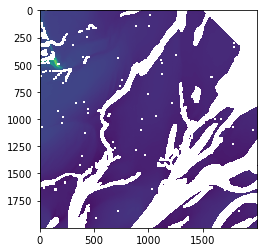

In [9]:
plt.imshow(x_val0[0,0,:,:])

In [10]:

def process(x_train, x_val, y_train, y_val,  size, bslice=True, cl2dim=True, Inf2zero=True):
    if bslice :
        x_train  = batchslice(x_train, size,x_train[0].shape[1],size, x_train.shape[0])
        x_val = batchslice(x_val,size, x_val[0].shape[1], size, x_val.shape[0])
        y_train = batchslice(y_train,size,y_train[0].shape[1],size,y_train.shape[0]).squeeze()
        y_val = batchslice(y_val,size,y_val[0].shape[1],size,y_val.shape[0]).squeeze()
        print(f"batch slice to {size}")
       
    if  cl2dim :    
        y_train = class2dim(y_train, classes)
        y_val = class2dim(y_val, classes)

        y_train=  np.moveaxis(y_train, -1, 1)
        y_val = np.moveaxis(y_val, -1, 1)
        print("classes are converted to channels")
        
    if Inf2zero : 
        x_train[x_train > 1e308] = 0 
        #np.nan
        x_val [x_val > 1e308] =0 
        y_train[y_train >1e308] = 0
        y_val[y_val> 1e308] = 0
        print("inf are converted to 0")
    return(x_train, x_val, y_train, y_val)

def myloader(trainX, trainY, valX,valY):

    train = TensorDataset(torch.Tensor(x_train[:,0:4,:,:]), torch.Tensor(y_train )) # create your datset
    train  = DataLoader(train, batch_size=bs) # create your dataloader
    
    vali= TensorDataset(torch.Tensor(x_val[:,0:4,:,:]),torch.Tensor(y_val   )) # create your datset
    vali = DataLoader(vali, batch_size=bs) # create your dataloader
    return train , vali 

In [11]:
x_train, x_val, y_train, y_val = process(x_train0, x_val0, y_train0, y_val0, size =size, bslice=False, cl2dim=True, Inf2zero=True)

classes are converted to channels
inf are converted to 0


In [12]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(2, 4, 2000, 2000) (2, 4, 2000, 2000) (2, 10, 2000, 2000) (2, 10, 2000, 2000)


In [13]:
'''
for wh in range(num_class):
    plot_imgs(
    org_imgs=x_val0[0:1,0, :,:], # required - original images
    mask_imgs=y_val[0:1,wh,:,:], # required - ground truth masks
    nm_img_to_plot=3) # optional - number of images to plot
'''

'\nfor wh in range(num_class):\n    plot_imgs(\n    org_imgs=x_val0[0:1,0, :,:], # required - original images\n    mask_imgs=y_val[0:1,wh,:,:], # required - ground truth masks\n    nm_img_to_plot=3) # optional - number of images to plot\n'

In [14]:
x_train, x_val, y_train, y_val = process(x_train0, x_val0, y_train0, y_val0, size =size, bslice=True, cl2dim=True, Inf2zero=True)

batch slice to 128
classes are converted to channels
inf are converted to 0


In [15]:

train_loader, valid_loader = myloader(x_train, y_train, x_val, y_val)


In [16]:
'''
for i, inputs in enumerate (train_loader):          
         print (inputs[0].size(),inputs[1].size())
'''



'\nfor i, inputs in enumerate (train_loader):          \n         print (inputs[0].size(),inputs[1].size())\n'

In [17]:
'''
%load_ext tensorboard
%tensorboard --logdir {logdir}
'''

'\n%load_ext tensorboard\n%tensorboard --logdir {logdir}\n'

In [18]:
GAMMA = 2
ALPHA = 0.8 # emphasize FP
BETA = 0.2 # more emphasize on FN

# combo loss
cl_ALPHA = 0.5 # < 0.5 penalises FP more, > 0.5 penalises FN more
cl_BETA = 0.5
CE_RATIO = 0.5 #weighted contribution of modified CE loss compared to Dice loss
e=1e-07

In [19]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


     
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, **kwargs):
        super(IoULoss, self).__init__(**kwargs)

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        #print(inputs.shape)
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #inputs = (inputs>0.5).float()
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()  
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth) 
                
        return 1 - IoU
    
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
 

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

class myLoss(torch.nn.Module):

    def __init__(self, pos_weight=1):
      super().__init__()
      self.pos_weight = pos_weight

    def forward(self, input, target):
      epsilon = 10 ** -44
      input = input.sigmoid().clamp(epsilon, 1 - epsilon)

      my_bce_loss = -1 * (self.pos_weight * target * torch.log(input)
                          + (1 - target) * torch.log(1 - input))
      add_loss = (target - 0.5) ** 2 * 4
      mean_loss = (my_bce_loss * add_loss).mean()
      return mean_loss
    
 

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss
    

In [20]:

class ComboLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=cl_ALPHA, beta=cl_BETA):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        intersection = (inputs * targets).sum()    
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        inputs = torch.clamp(inputs, e, 1.0 - e)       
        out = - (cl_ALPHA * ((targets * torch.log(inputs)) + ((1 - cl_ALPHA) * (1.0 - targets) * torch.log(1.0 - inputs))))
        weighted_ce = out.mean(-1)
        combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
        
        return combo

In [21]:
 
# model, criterion, optimizer
#model =  torchvision.models.segmentation.fcn_resnet50(pretrained=False, progress=True, num_classes=num_class)
#model =Unet(num_classes=num_class, in_channels=4, num_channels=64, num_blocks=4)# catalyst Unet
#model = ResnetUnet(num_classes=num_class) # can only take 3 channels 
 
#ComboLoss()
#IoULoss()
#FocalTverskyLoss()
#"sigmoid" nn.BCELoss()
#smp.utils.losses.DiceLoss()
#WithLogits 
#myLoss()
#nn.BCEWithLogitsLoss() # this and myLoss() can run but gradient does not descent. 
# nn.CrossEntropyLoss()  # the type should be Long


In [22]:
x_train.shape

(450, 4, 128, 128)

In [23]:
def show(img):
    npimg = img.numpy()
    plt.imshow(npimg[1,])
    plt.show()

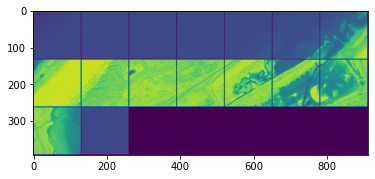

In [24]:
# get some random training images
tl = iter(train_loader)
images, lables = tl.next()
#print(images.shape)
torchvision.utils.make_grid(images).shape
show(torchvision.utils.make_grid(images, nrow = 7))
 

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
class myCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, outputs, labels, bs):


        batch_size = outputs.size()[0]            # batch_size
        outputs = F.log_softmax(outputs, dim=1)   # compute the log of softmax values
        outputs = outputs[range(batch_size), labels] # pick the values corresponding to the labels
        return -torch.sum(outputs)/bs

In [27]:
valid_loss_history = []
train_loss_history = []

PATH = '../U_net.pth'
def train(trainloader,testloader, num_class, n_epoch, savepath):
    model = smp.Unet('resnet34', classes=num_class, in_channels=num_channel, activation = 'softmax')   
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    criterion = IoULoss()
    #nn.CrossEntropyLoss() 
    #FocalTverskyLoss() 
    tot = 0
    label_type = torch.float32 if num_class  == 1 else torch.long
  
    for epoch in range(n_epoch):
        train_loss  = 0.0
        val_loss = 0.0
        for i, data in enumerate(trainloader):
 
            images = data[0].to(device = device)
            labels = data[1].to(device = device, dtype = label_type)
            #images = Variable(images.cuda())
            #labels = Variable(labels.cuda(), requires_grad=False)

            optimizer.zero_grad()
            output = model(images)
            #output = torch.sigmoid(output)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss_history.append(train_loss/(i+1))

        
        
        for i, data in enumerate(valid_loader):
                valimages = data[0].to(device = device)
                vallabels = data[1].to(device = device, dtype = label_type)
               
                with torch.no_grad():      
                    outputs = model(valimages)
                    loss = criterion(outputs, vallabels)
                    val_loss += loss.item()
        valid_loss_history.append(val_loss/i)
        if epoch % 20 == 19:    # print every 10 mini-batches
            print('Epoch: %d, validation Loss: %.4f, validation Loss: %.4f' %
                      (epoch + 1, train_loss/i, val_loss/(i+1)))

        running_loss = 0.0             
                
    
 
    torch.save(model.state_dict(), savepath)

    return model

 
model = train( train_loader, valid_loader, num_class=10, n_epoch=EPOCH, savepath = PATH) 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


/opt/conda/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Epoch: 20, validation Loss: 0.6114, validation Loss: 0.4608
Epoch: 40, validation Loss: 0.4972, validation Loss: 0.4656
Epoch: 60, validation Loss: 0.4154, validation Loss: 0.4737
Epoch: 80, validation Loss: 0.4016, validation Loss: 0.4449
Epoch: 100, validation Loss: 0.3697, validation Loss: 0.4603
Epoch: 120, validation Loss: 0.3769, validation Loss: 0.4147
Epoch: 140, validation Loss: 0.3911, validation Loss: 0.4178
Epoch: 160, validation Loss: 0.3509, validation Loss: 0.4731
Epoch: 180, validation Loss: 0.3483, validation Loss: 0.4616
Epoch: 200, validation Loss: 0.3518, validation Loss: 0.4422
Epoch: 220, validation Loss: 0.3478, validation Loss: 0.4427
Epoch: 240, validation Loss: 0.3363, validation Loss: 0.5246
Epoch: 260, validation Loss: 0.2986, validation Loss: 0.4551
Epoch: 280, validation Loss: 0.3049, validation Loss: 0.4205
Epoch: 300, validation Loss: 0.2993, validation Loss: 0.4283
Epoch: 320, validation Loss: 0.2305, validation Loss: 0.4499
Epoch: 340, validation Loss:

In [28]:
# load model
net= smp.Unet(classes=10, in_channels=num_channel, activation = 'softmax')    
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [29]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()
pre = net(images)

In [30]:
'''
for wh in range(10):
    plt.imshow( pre.detach().numpy()[1,wh,:,:])
    plt.colorbar()
    plt.show()
'''
    

'\nfor wh in range(10):\n    plt.imshow( pre.detach().numpy()[1,wh,:,:])\n    plt.colorbar()\n    plt.show()\n'

In [31]:
'''
from scipy import stats
a = np.sum(pre.detach().numpy()[1,:,:,:], axis = 0)
 
print(np.amin(a),np.amax(a))
''' 
#stats.describe(a)

'\nfrom scipy import stats\na = np.sum(pre.detach().numpy()[1,:,:,:], axis = 0)\n \nprint(np.amin(a),np.amax(a))\n'

In [32]:
#import inspect
#inspect.signature(runner.train)

In [33]:
#sigmoid = lambda x: 1/(1 + np.exp(-x))


In [34]:
'''
for wc in range (10) :
    
        #for the first tile only
    result = np.zeros((1,size, size))
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data 
            output1 = net(images)
            output1 = (output1   > .5).detach().numpy().astype(int)
            p1 = output1[:,wc,] #np.sum(output1[0,], axis = 0).astype(bool).astype(int)    
'''



'\nfor wc in range (10) :\n    \n        #for the first tile only\n    result = np.zeros((1,size, size))\n    with torch.no_grad():\n        for data in valid_loader:\n            images, labels = data \n            output1 = net(images)\n            output1 = (output1   > .5).detach().numpy().astype(int)\n            p1 = output1[:,wc,] #np.sum(output1[0,], axis = 0).astype(bool).astype(int)    \n'

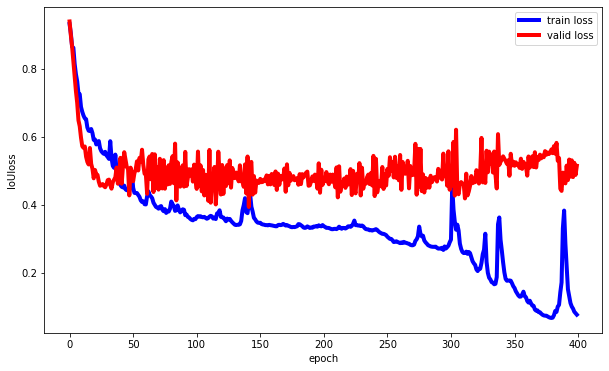

In [35]:
x = np.arange(EPOCH)

fig = plt.figure(figsize=(10, 6))
plt.plot(x, train_loss_history, label='train loss', lw=4, color='blue')
plt.plot(x, valid_loss_history, label='valid loss', lw=4, color='red')
plt.xlabel('epoch', fontsize=10)
plt.ylabel('IoUloss',fontsize=10)
plt.legend()
plt.show()


/opt/conda/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


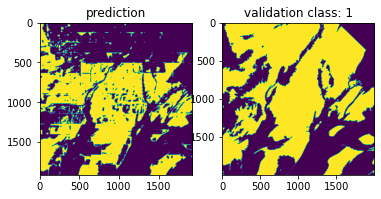

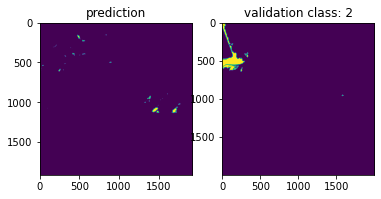

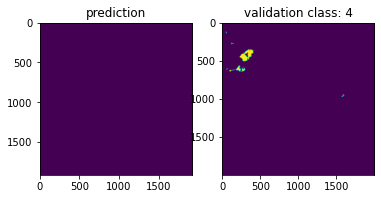

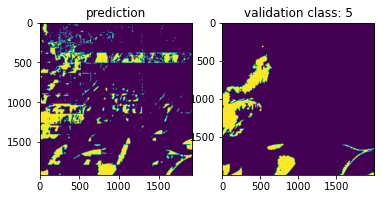

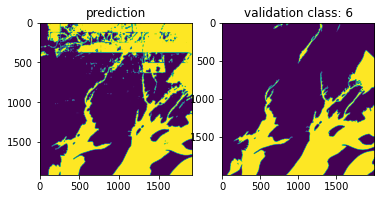

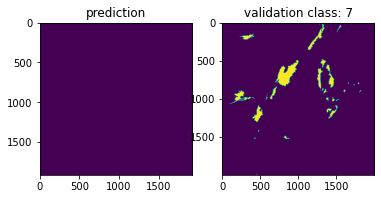

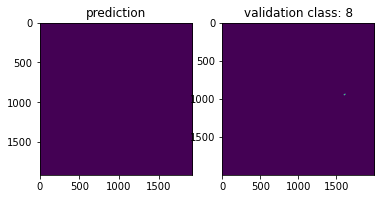

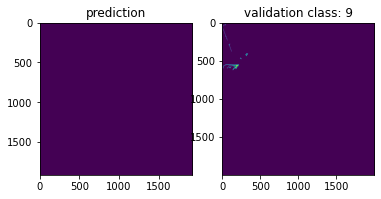

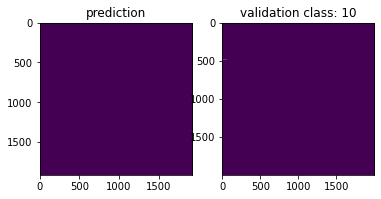

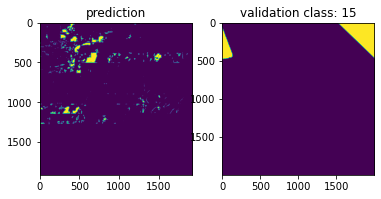

In [36]:
numimag = np.sqrt(x_val.shape[0]/2).astype(int)
num = (numimag*numimag+1).astype(int)
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8)) 
#for ii,axi in enumerate(ax.flat):
classes = [1,2,4,5,6,7,8,9,10,15]
for wc in range (10) :
    
        #for the first tile only
    result = np.zeros((1,size, size))
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data 
            output1 = net(images)
            output1 = (output1   > .5).detach().numpy().astype(int)
            p1 = output1[:,wc,] #np.sum(output1[0,], axis = 0).astype(bool).astype(int)    
            
            result = np.concatenate((result, p1),axis=0)
           # print(result.shape)     
    result = result[1:num,:,:]

    result= np.moveaxis(result, 0, -1)

    big = np.zeros((numimag*size, numimag*size))

    for j in range(numimag):    
        for i in range(numimag):
            big[j*size: (j+1)*size,i*size: (i+1)*size]= result[:,:,i+j*numimag]


    plt.subplot(1,2,1)
    plt.title('prediction')
    plt.imshow(big)
    plt.subplot(1,2,2)
    plt.imshow(y_val0[0,]==classes[wc])
    plt.title(f'validation class: {classes[wc]}')
    plt.show()


In [37]:
label_all =  range (10)
#string.ascii_lowercase
 
ori_val = classes # random numpy numbers

enum_val = [x for n, x in enumerate(ori_val) if x not in ori_val[:n]]

sort_val = np.sort(enum_val)
dic_label = {}
for ind, v in enumerate(sort_val):
    dic_label[v] = label_all[ind]
print(dic_label) 

y_label = np.zeros((big.shape[0],big.shape[1]))
for i in range(big.shape[0]):
    for j in range(big.shape[1]):
        y_label[i,j] = dic_label[y_val0[0,i,j]]

{1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 15: 9}


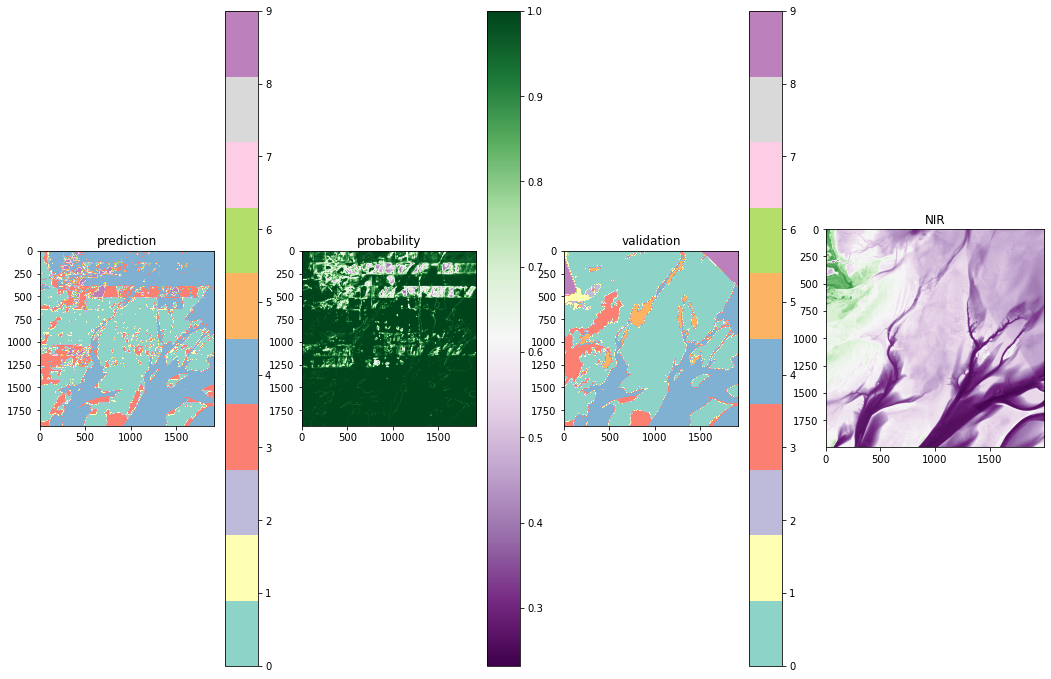

In [38]:
result = np.zeros((1,size, size))
result2 = np.zeros((1,size, size))
with torch.no_grad():
        for data in valid_loader:
            images, labels = data 
            output1 = net(images)
            p1 = torch.argmax(output1, dim = 1).cpu().numpy()
            result = np.concatenate((result, p1),axis=0)
           
            p2,_ = torch.max(output1,  1)
           
            result2 = np.concatenate((result2, p2.numpy()),axis=0)
            #print(p1.shape, result.shape) 
             
result = result[1:num,:,:]

result= np.moveaxis(result, 0, -1)

result2 = result2[1:num,:,:]

result2= np.moveaxis(result2, 0, -1)
#np.place(result, result>-1, classes) 
#result[result==0]='nan' 
 
big = np.zeros((numimag*size, numimag*size))
big2 = np.zeros((numimag*size, numimag*size))
 
for j in range(numimag):    
        for i in range(numimag):
            big[j*size: (j+1)*size,i*size: (i+1)*size]= result[:,:,i+j*numimag]
            big2[j*size: (j+1)*size,i*size: (i+1)*size]= result2[:,:,i+j*numimag]
            

#from scipy.stats import rankdata
#val = rankdata(y_val0[0,]).reshape(1000, 1000)

 

cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:10])
plt.figure(figsize=(18,18))
plt.subplot(1,4,1)
plt.title('prediction')
plt.imshow(big,cmap=cmap)
plt.colorbar()

plt.subplot(1,4,2)
plt.title('probability')
plt.imshow(big2,cmap="PRGn")
plt.colorbar()


plt.subplot(1,4,3)
plt.imshow(y_label,cmap=cmap)
plt.colorbar()
plt.title(f'validation')
plt.subplot(1,4,4)
plt.imshow(x_val0[0,1,],cmap=plt.get_cmap("PRGn"))
#plt.colorbar()
plt.title(f'NIR')

plt.show()

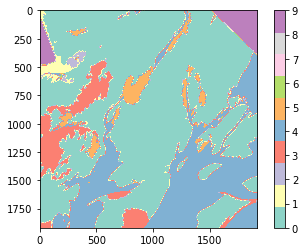

In [39]:
plt.imshow(y_label,cmap=cmap)
plt.colorbar()



In [40]:
np.where(y_val0==1)
classes

[1, 2, 4, 5, 6, 7, 8, 9, 10, 15]

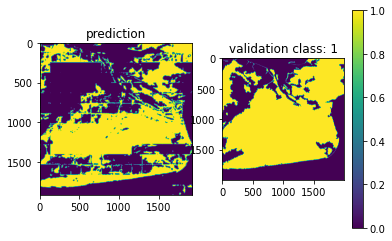

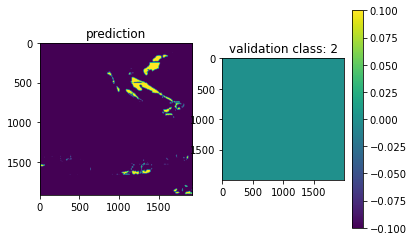

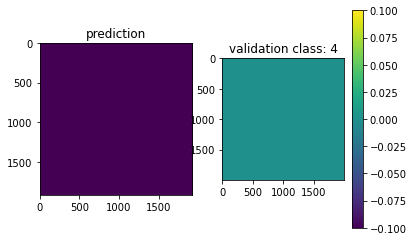

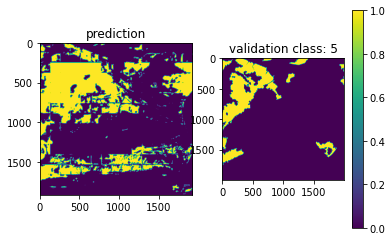

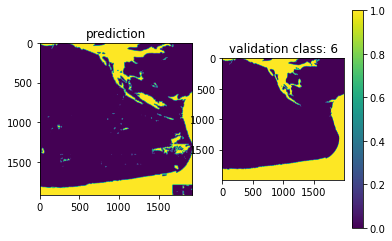

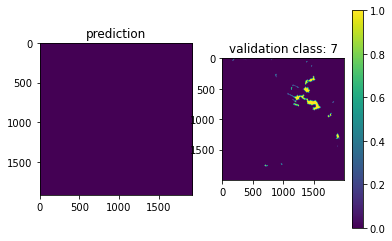

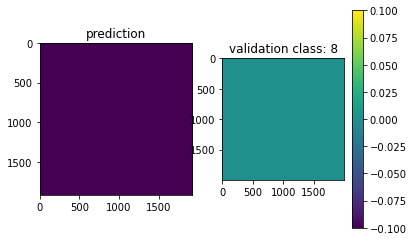

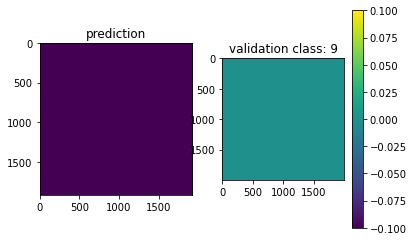

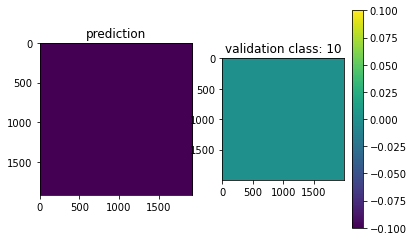

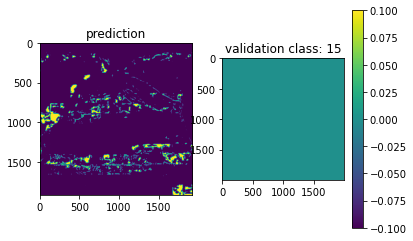

In [41]:
numimag = np.sqrt(x_val.shape[0]/2).astype(int)
num = (numimag*numimag+1).astype(int)
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8)) 
#for ii,axi in enumerate(ax.flat):
classes = [1,2,4,5,6,7,8,9,10,15]
for wc in range (10) :
    
        #for the first tile only
    result = np.zeros((1,size, size))
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data 
            output1 = net(images)
            output1 = (output1   > .5).detach().numpy().astype(int)
            p1 = output1[:,wc,] #np.sum(output1[0,], axis = 0).astype(bool).astype(int)    

            result = np.concatenate((result, p1),axis=0)
           # print(result.shape)     
    result = result[num:,:,:]

    result= np.moveaxis(result, 0, -1)

    big = np.zeros((numimag*size, numimag*size))

    for j in range(numimag):    
        for i in range(numimag):
            big[j*size: (j+1)*size,i*size: (i+1)*size]= result[:,:,i+j*numimag]


    plt.subplot(1,2,1)
    plt.title('prediction')
    plt.imshow(big)
    plt.subplot(1,2,2)
    plt.imshow(y_val0[1,]==classes[wc])
    plt.title(f'validation class: {classes[wc]}')
    plt.colorbar()
    plt.show()

In [42]:
'''
x_train, x_val, y_train, y_val = process(x_train0, x_val0, y_train0, y_val0, size =size, bslice=True, cl2dim=False, Inf2zero=True)
 
train_loader, valid_loader = myloader(x_train, y_train, x_val, y_val)

PATH = '../U_net.pth'
def train(trainloader,testloader, num_class, n_epoch, savepath):
    model = smp.Unet(classes=10, in_channels=3, activation = 'softmax')   
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    criterion = nn.CrossEntropyLoss()
    tot = 0
    label_type = torch.float32 if num_class  == 1 else torch.long
  
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
 
            images = data[0].to(device = device)
            labels = data[1].to(device = device, dtype = label_type)
            #images = Variable(images.cuda())
            #labels = Variable(labels.cuda(), requires_grad=False)

            #optimizer.zero_grad()
            output = model(images)
            #output = torch.sigmoid(output)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 4 == 3:    # print every 10 mini-batches
                print('Epoch: %d, Loss: %.4f' %
                      (epoch + 1, running_loss/4))
        running_loss = 0.0
        
        for i, data in enumerate(valid_loader):
                valimages = data[0].to(device = device)
                vallabels = data[1].to(device = device, dtype = label_type)
               
                with torch.no_grad():      
                    outputs = model(valimages)
                    loss = criterion(outputs, vallabels)
                    running_loss += loss.item()

                    if i % 4 == 3:    # print every 10 mini-batches
                        print('Epoch: %d, validation Loss: %.4f' %
                      (epoch + 1, running_loss/4))

        running_loss = 0.0             
                
    
 
    torch.save(model.state_dict(), savepath)

    return model

 
model = train( train_loader, valid_loader, num_class=1, n_epoch=10, savepath = PATH) 
'''

"\nx_train, x_val, y_train, y_val = process(x_train0, x_val0, y_train0, y_val0, size =size, bslice=True, cl2dim=False, Inf2zero=True)\n \ntrain_loader, valid_loader = myloader(x_train, y_train, x_val, y_val)\n\nPATH = '../U_net.pth'\ndef train(trainloader,testloader, num_class, n_epoch, savepath):\n    model = smp.Unet(classes=10, in_channels=3, activation = 'softmax')   \n    model.to(device)\n\n    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)\n    criterion = nn.CrossEntropyLoss()\n    tot = 0\n    label_type = torch.float32 if num_class  == 1 else torch.long\n  \n    for epoch in range(n_epoch):\n        running_loss = 0.0\n        for i, data in enumerate(trainloader):\n \n            images = data[0].to(device = device)\n            labels = data[1].to(device = device, dtype = label_type)\n            #images = Variable(images.cuda())\n            #labels = Variable(labels.cuda(), requires_grad=False)\n\n            #optimizer.zero_grad()\n            output = model(i

In [43]:
'''
torch.save(model.state_dict(),'model.pt')
for wc in range (10) :
    def extra(i,data):
        if i == 0:
            d = data[15,wc,]#np.sum(data[15,],axis=0).astype(bool).astype(int)
        else:
            d=[]
            for x in range(15-i,16):
                d.append(data[x,wc,])
            d = np.concatenate(d,axis=1)
        return d      

    runner_out = runner.predict_loader(loader=loaders["valid"])
    number=1
    a= np.empty([])
    tot=np.empty((128*2,1920*2))
    xx =0
    #for the first tile only
    for i, output in enumerate (runner_out):
        if i in range(0,15):#batches
            #print(f"{i} th batch")
            output1 =  output["logits"].cpu()
            output1 = (sigmoid(output1)  > .7).detach().numpy().astype(int)
            p1 = output1[0,wc,] #np.sum(output1[0,], axis = 0).astype(bool).astype(int)
            
            number+=1
            if xx>0 and xx!=14:
                p1 = np.append(next_row,p1,axis=1)
                number+=(1*(xx+1))
            if xx == 14:
                p1 = np.append(next_row,p1,axis=1)
                number+=1
            else:
                for j in range (1,15-xx):#images in 1 batch
                    output2 = output1[j,wc,]#np.sum(output1[j,], axis = 0).astype(bool).astype(int)
                    p1=np.append(p1,output2,axis=1)
                    number+=1
                next_row = extra(xx,output1)
                xx+=1
        else:
            continue
        tot = np.append(tot,p1,axis=0)

        #print('tot',tot.shape,number)



    tot=tot[128*2:,:]
    #print(tot.shape[0]/128,tot.shape[1]/128,number)  
    plt.imshow(tot)
    plt.title(f'class: {wc}')
    plt.show()
'''

'\ntorch.save(model.state_dict(),\'model.pt\')\nfor wc in range (10) :\n    def extra(i,data):\n        if i == 0:\n            d = data[15,wc,]#np.sum(data[15,],axis=0).astype(bool).astype(int)\n        else:\n            d=[]\n            for x in range(15-i,16):\n                d.append(data[x,wc,])\n            d = np.concatenate(d,axis=1)\n        return d      \n\n    runner_out = runner.predict_loader(loader=loaders["valid"])\n    number=1\n    a= np.empty([])\n    tot=np.empty((128*2,1920*2))\n    xx =0\n    #for the first tile only\n    for i, output in enumerate (runner_out):\n        if i in range(0,15):#batches\n            #print(f"{i} th batch")\n            output1 =  output["logits"].cpu()\n            output1 = (sigmoid(output1)  > .7).detach().numpy().astype(int)\n            p1 = output1[0,wc,] #np.sum(output1[0,], axis = 0).astype(bool).astype(int)\n            \n            number+=1\n            if xx>0 and xx!=14:\n                p1 = np.append(next_row,p1,axis

In [44]:
''' # probabilistic
runner_out = runner.predict_loader(loader=loaders["valid"])
wh = 2
plt.figure(figsize=(18,18))
for i, output in enumerate (runner_out):   
    if i == 0: 
        print(i)
        for j in range(1,10): 
            
            plt.subplot(10,3, 1+3*(j-1))
            plt.imshow(output['logits'].cpu()[wh,j,])
            plt.subplot(10,3, 2+3*(j-1))
            plt.imshow(validation[wh,2,])
            plt.subplot(10, 3, 3+3*(j-1))
            plt.imshow(new_mas_val[wh,j,]) 
''' 
'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-44-19b06681cfca>, line 17)

In [45]:

''' plot
#plt.style.use("ggplot")
#%matplotlib inline

sigmoid = lambda x: 1/(1 + np.exp(-x))

for i, (input, output) in enumerate(zip(validation, runner_out)):
    image, mask = input
    
    threshold = 0.5
    
    plt.figure(figsize=(10,8))
    
    
    plt.imshow(image, 'gray')
    
    plt.subplot(1, 3, 2)
    output =  output["logits"].copy()
    output = (output > threshold).astype(np.uint8)
    plt.imshow(output, "gray")
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, "gray")
    
    plt.show()
'''

' plot\n#plt.style.use("ggplot")\n#%matplotlib inline\n\nsigmoid = lambda x: 1/(1 + np.exp(-x))\n\nfor i, (input, output) in enumerate(zip(validation, runner_out)):\n    image, mask = input\n    \n    threshold = 0.5\n    \n    plt.figure(figsize=(10,8))\n    \n    \n    plt.imshow(image, \'gray\')\n    \n    plt.subplot(1, 3, 2)\n    output =  output["logits"].copy()\n    output = (output > threshold).astype(np.uint8)\n    plt.imshow(output, "gray")\n    \n    plt.subplot(1, 3, 3)\n    plt.imshow(mask, "gray")\n    \n    plt.show()\n'

How to update a model
https://heartbeat.fritz.ai/image-segmentation-with-transfer-learning-pytorch-5ada7121c6ab

In [46]:
'''#for loop way of class2dimm
def class2dim2 (mask, num_class):
    
    new_mask = np.reshape(np.tile(mask, num_class), ( mask.shape[0], mask.shape[1],mask.shape[2], num_class))
 
    for j in range(mask.shape[0]):
         aslice = new_mask[j,]
         amask = mask[j,]
         for i in range(num_class):
             aslice[:,:,i] = np.multiply(amask == i+1,1)        
         new_mask[j,]=aslice
    return new_mask
    
a = class2dim2(y_train, num_class)
a.shape
comparison = a == new_mask
equal_arrays = comparison.all()
print(equal_arrays)
'''




'#for loop way of class2dimm\ndef class2dim2 (mask, num_class):\n    \n    new_mask = np.reshape(np.tile(mask, num_class), ( mask.shape[0], mask.shape[1],mask.shape[2], num_class))\n \n    for j in range(mask.shape[0]):\n         aslice = new_mask[j,]\n         amask = mask[j,]\n         for i in range(num_class):\n             aslice[:,:,i] = np.multiply(amask == i+1,1)        \n         new_mask[j,]=aslice\n    return new_mask\n    \na = class2dim2(y_train, num_class)\na.shape\ncomparison = a == new_mask\nequal_arrays = comparison.all()\nprint(equal_arrays)\n'

In [47]:
''' # Not using catalyst, the lost is a different format 

from torch.utils.data import DataLoader, TensorDataset 
def myloader(trainX, trainY, valX,valY):
    train = TensorDataset(torch.Tensor(trainX[:,0:3,:,:]), torch.Tensor(trainY )) # create your datset
    train  = DataLoader(train, batch_size=bs) # create your dataloader
    
    vali= TensorDataset(torch.Tensor(valX[:,0:3,:,:]),torch.Tensor(valY  )) # create your datset
    vali = DataLoader(vali, batch_size=bs) # create your dataloader
    return train , vali 

train_loader, valid_loader = myloader(training, new_mask, validation, new_mas_val)
 # torch.LongTensor() for some losses
CLASSES = [format(x, '2d') for x in  classes]
 
model = smp.Unet(classes=len(CLASSES), in_channels=3,activation="sigmoid")
#newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
#print(model)

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

print(len(CLASSES))
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
#model = smp.FPN(
#    encoder_name=ENCODER, 
#    encoder_weights=ENCODER_WEIGHTS, 
#    classes=len(CLASSES), 
#    activation=ACTIVATION,
#)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

loss = smp.utils.losses.DiceLoss()
#loss=nn.BCELoss(reduction = 'sum')
#WithLogits
#loss = nn.BCELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)
max_score = 0

for i in range(0, EPOCH):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5

        print('Decrease decoder learning rate to 1e-5!')

best_model = torch.load('./best_model.pth')
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
for i in range(10):
    x_tensor = torch.from_numpy(validation[:,0:3,:,:]).to(DEVICE)     
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy())
        
    visualize( 
        predicted_mask=pr_mask[2,i,:,:]
    )
plt.imshow(validation[2,1,:,:])
plt.show()
plt.imshow(y_val[2,:,:])
''' 

' # Not using catalyst, the lost is a different format \n\nfrom torch.utils.data import DataLoader, TensorDataset \ndef myloader(trainX, trainY, valX,valY):\n    train = TensorDataset(torch.Tensor(trainX[:,0:3,:,:]), torch.Tensor(trainY )) # create your datset\n    train  = DataLoader(train, batch_size=bs) # create your dataloader\n    \n    vali= TensorDataset(torch.Tensor(valX[:,0:3,:,:]),torch.Tensor(valY  )) # create your datset\n    vali = DataLoader(vali, batch_size=bs) # create your dataloader\n    return train , vali \n\ntrain_loader, valid_loader = myloader(training, new_mask, validation, new_mas_val)\n # torch.LongTensor() for some losses\nCLASSES = [format(x, \'2d\') for x in  classes]\n \nmodel = smp.Unet(classes=len(CLASSES), in_channels=3,activation="sigmoid")\n#newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))\n#print(model)\n\nENCODER = \'se_resnext50_32x4d\'\nENCODER_WEIGHTS = \'imagenet\'\n\nprint(len(CLASSES))\nACTIVATION = \'sigmoid\' # could be None fo